In [1]:
import h5py

import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics

import sklearn.metrics 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.utils import class_weight

import matplotlib.pyplot as plt

2021-10-15 13:50:09.584592: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
np.random.seed(20211012)
tf.random.set_seed(20211012)

## Load Data

In [3]:
CBIS = h5py.File('../input/cbisddsm/CBIS-DDSM.hdf5', 'r')
CBIS.keys()

<KeysViewHDF5 ['Calc-Test_ROI', 'Calc-Test_ROI_csv', 'Calc-Test_csv', 'Calc-Test_image', 'Calc-Training_ROI', 'Calc-Training_ROI_csv', 'Calc-Training_csv', 'Calc-Training_image', 'Mass-Test_ROI', 'Mass-Test_ROI_csv', 'Mass-Test_csv', 'Mass-Test_image', 'Mass-Training_ROI', 'Mass-Training_ROI_csv', 'Mass-Training_csv', 'Mass-Training_image']>

### CSV

In [4]:
Mass_Training_image_csv = CBIS['Mass-Training_csv'][:]
Calc_Training_image_csv = CBIS['Calc-Training_csv'][:]

Mass_Training_ROI_csv = CBIS['Mass-Training_ROI_csv'][:]
Calc_Training_ROI_csv = CBIS['Calc-Training_ROI_csv'][:]

Mass_Test_image_csv = CBIS['Mass-Test_csv'][:]
Calc_Test_image_csv = CBIS['Calc-Test_csv'][:]

Mass_Test_ROI_csv = CBIS['Mass-Test_ROI_csv'][:]
Calc_Test_ROI_csv = CBIS['Calc-Test_ROI_csv'][:]

### Image

In [5]:
Mass_Training_image = CBIS['Mass-Training_image'][:]
Calc_Training_image = CBIS['Calc-Training_image'][:]

Mass_Test_image = CBIS['Mass-Test_image'][:]
Calc_Test_image = CBIS['Calc-Test_image'][:]

Mass_Training_ROI = CBIS['Mass-Training_ROI'][:]
Calc_Training_ROI = CBIS['Calc-Training_ROI'][:]

Mass_Test_ROI = CBIS['Mass-Test_ROI'][:]
Calc_Test_ROI = CBIS['Calc-Test_ROI'][:]

## Data Preparation

### Data Balance

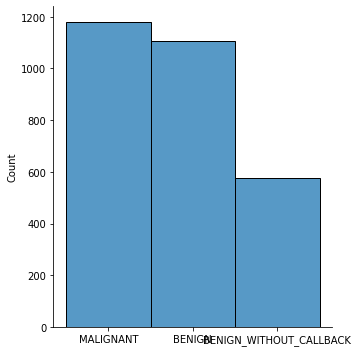

In [6]:
sns.displot(np.concatenate(
    [Mass_Training_ROI_csv['pathology'], 
     Calc_Training_ROI_csv['pathology']])
           )

## Response variables

### Pathology

Benign cases are formed from screening exams in which something suspicious was found, but was determined to not be malignant (by pathology, ultrasound or some other means). The term benign without callback is used to identify benign cases in which no additional films or biopsy was done to make the benign finding. These cases, however, contained something interesting enough for the radiologist to mark. **A small number of cancer cases may contain, in addition to one or more regions that are path-proven malignant, one or more regions that are unproven.** These are suspicious regions for which there is no path result. 

Since there are only a small number of malignant case in benign without callback, we will map 'benign without callback' into benign

In [7]:
def modifyPathology(df):
    x = df['pathology']
    df['pathology'] = np.where(x == b'BENIGN_WITHOUT_CALLBACK', b'BENIGN', x)
    return df

In [8]:
Mass_Training_ROI_csv = modifyPathology(Mass_Training_ROI_csv)
Calc_Training_ROI_csv = modifyPathology(Calc_Training_ROI_csv)
Mass_Test_ROI_csv = modifyPathology(Mass_Test_ROI_csv)
Calc_Test_ROI_csv = modifyPathology(Calc_Test_ROI_csv)

For each X-ray image, multiple abnormality may found. We consider that if any of the abnormality is malignant, the image will be signed as malignant. We also defines benign as 0 and malignant as 1.

In [9]:
def class2onehot(array, n_class = 2):
    b = np.zeros((array.size, 2), dtype = np.int32)
    b[np.arange(array.size),array] = 1
    return b

def AbnormalityAggregate(images, roi):
    Pathologys_array = []
    for img in tqdm(images):
        id_match = roi[roi['patient_id'] == img[0]]
        breast_match = id_match[id_match['left or right breast'] == img[1]]
        view_match = breast_match[breast_match['image view'] == img[2]]
        
        Pathology = 0
        for i in view_match:
            if(i[4] == b'MALIGNANT'):
                Pathology = 1
                break
        Pathologys_array.append(Pathology)
        onehot = class2onehot(np.array(Pathologys_array, dtype = np.int32))
    return onehot

In [10]:
y1_Mass_Training_Pathology = AbnormalityAggregate(Mass_Training_image_csv, Mass_Training_ROI_csv)
y1_Calc_Training_Pathology = AbnormalityAggregate(Calc_Training_image_csv, Calc_Training_ROI_csv)
y1_Mass_Test_Pathology = AbnormalityAggregate(Mass_Test_image_csv, Mass_Test_ROI_csv)
y1_Calc_Test_Pathology = AbnormalityAggregate(Calc_Test_image_csv, Calc_Test_ROI_csv)

100%|██████████| 284/284 [00:00<00:00, 17568.28it/s]


Since the model should and will only one output for ROI. We will merge all the ROI image for a patient into one image

In [11]:
def ROIMerge(images_csv, roi_csv, roi):
    roi_array = np.zeros(shape = (len(images_csv), 224,224), dtype = np.int32)
    for i in tqdm(range(len(images_csv))):
        img = images_csv[i]
        id_match     = roi_csv['patient_id'] == img[0]
        breast_match = roi_csv['left or right breast'] == img[1]
        view_match   = roi_csv['image view'] == img[2]
        
        all_match = id_match & breast_match & view_match
        
        roi_array[i] = (np.sum(roi[all_match], axis = 0) > 0)
        
    return roi_array

In [12]:
y2_Mass_Training_ROI = ROIMerge(Mass_Training_image_csv, Mass_Training_ROI_csv, Mass_Training_ROI)
y2_Calc_Training_ROI = ROIMerge(Calc_Training_image_csv, Calc_Training_ROI_csv, Calc_Training_ROI)
y2_Mass_Test_ROI = ROIMerge(Mass_Test_image_csv, Mass_Test_ROI_csv, Mass_Test_ROI)
y2_Calc_Test_ROI = ROIMerge(Calc_Test_image_csv, Calc_Test_ROI_csv, Calc_Test_ROI)

100%|██████████| 284/284 [00:00<00:00, 4600.30it/s]


### Data concatenating

In [13]:
X_train = np.concatenate([Mass_Training_image, Calc_Training_image])[..., np.newaxis]
X_test = np.concatenate([Mass_Test_image, Calc_Test_image])[..., np.newaxis]

Y1_train = np.concatenate([y1_Mass_Training_Pathology, y1_Calc_Training_Pathology])
Y1_test = np.concatenate([y1_Mass_Test_Pathology, y1_Calc_Test_Pathology])

Y2_train = np.concatenate([y2_Mass_Training_ROI, y2_Calc_Training_ROI])
Y2_test = np.concatenate([y2_Mass_Test_ROI, y2_Calc_Test_ROI])

### Grayscale to RGB

In [14]:
X_train = np.concatenate([X_train,X_train,X_train], axis =3)
X_test = np.concatenate([X_test,X_test,X_test], axis =3)


### Random shuffle and Train validation split

In [15]:
shuffle_order = np.arange(len(X_train))
np.random.shuffle(shuffle_order)
shuffle_order

array([1972, 1051, 1814, ...,   70, 1559,  427])

In [16]:
validation_size = .2
validation_size = int(len(shuffle_order)*validation_size)

In [17]:
train_idx = shuffle_order[validation_size:]
validation_idx = shuffle_order[:validation_size]

In [18]:
X_val = X_train[validation_idx]
Y1_val = Y1_train[validation_idx]
Y2_val = Y2_train[validation_idx]

In [19]:
X_train = X_train[train_idx]
Y1_train = Y1_train[train_idx]
Y2_train = Y2_train[train_idx]

### ROI class weight

Text(0.5, 0, 'Class')

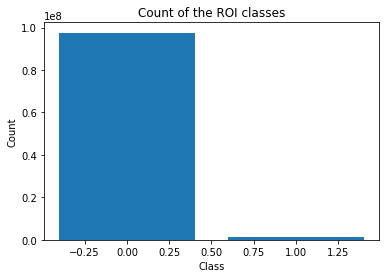

In [20]:
unique, count = np.unique(Y2_train.flatten(), return_counts = True)
plt.bar(unique, count)
plt.title('Count of the ROI classes')
plt.ylabel('Count')
plt.xlabel('Class')

Since the normal area is sigificantly more than abnormal area, we will give heavily weight on malignant class. https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

In [21]:
ROIweights = class_weight.compute_class_weight('balanced',
                                                unique,
                                                Y2_train.flatten())
ROIweights = {0: ROIweights[0], 1: ROIweights[1]}
ROIweights

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.5057283710819899, 1: 44.14242407165393}

## Model 1: Single tasking

In [22]:
def model1_build():
    tf.random.set_seed(20211012)
    EfficientNet_encode = keras.applications.EfficientNetB0(include_top=False, 
                                                            input_shape = (224,224,3),
                                                            weights='imagenet', 
                                                            pooling = 'avg')
    
    backbone = keras.Model(inputs = EfficientNet_encode.layers[0].output, 
                        outputs = EfficientNet_encode.layers[-1].output,
                        name = "EfficientNetB0"
                       )
    
    input_layer = layers.Input((224,224,3), name = "Input Layer")
    
    x = backbone(input_layer)
    
    
    x = layers.Flatten()(x)
    x = layers.Dense(units=1024, activation=tf.nn.leaky_relu)(x)
    x = layers.Dense(units=512, activation=tf.nn.leaky_relu)(x)
    x = layers.Dense(units=128, activation=tf.nn.leaky_relu)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(units=2, activation='softmax', name="output")(x)
    
    model = keras.Model(input_layer, out)
    model.compile(loss = keras.losses.CategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(learning_rate = 0.001), 
                  metrics=[metrics.CategoricalAccuracy()])

    return model

In [23]:
m1 = model1_build()

2021-10-15 13:50:54.583376: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-15 13:50:54.586700: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-15 13:50:54.640915: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-15 13:50:54.641545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-15 13:50:54.641606: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-15 13:50:54.667295: I tensorflow/stream_executor/platform/def

16711680/16705208 [==============================] - 0s 0us/step


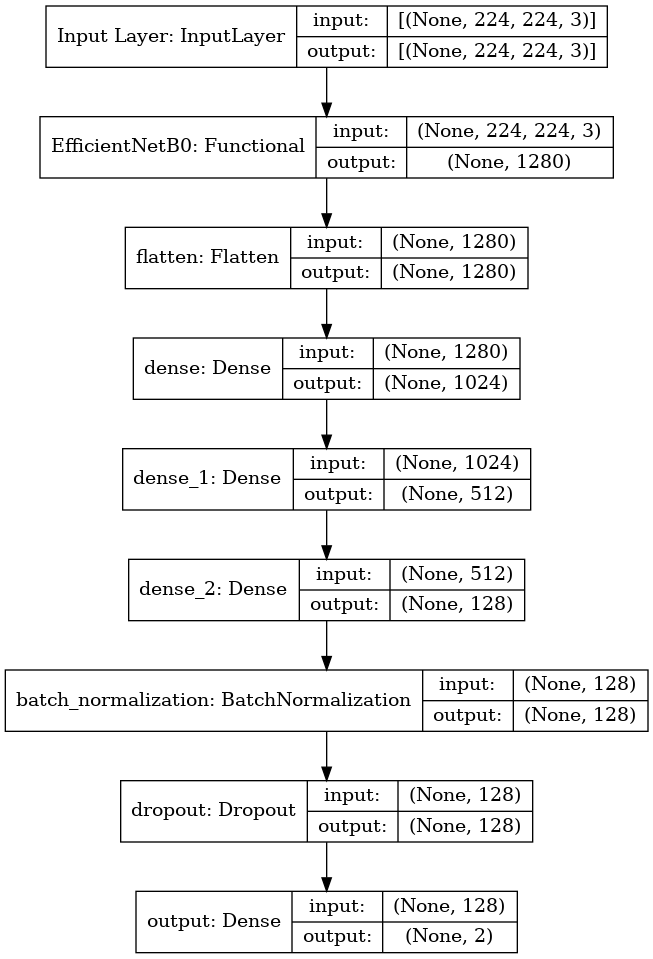

In [24]:
keras.utils.plot_model(m1,show_shapes=True)

In [25]:
!mkdir -p /kaggle/working/m1
model_checkpoint_callback_m1 = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/m1/m1-{epoch:02d}.hdf5',
    save_best_only=False,
    save_weights_only=False)

In [26]:
History = m1.fit(
    x = X_train, 
    y = Y1_train,
    validation_data = (X_val, Y1_val),
    batch_size = 100,
    epochs=30,
    verbose = 1,
    callbacks=model_checkpoint_callback_m1
)

2021-10-15 13:51:01.295397: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-15 13:51:01.307179: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000175000 Hz


Epoch 1/30


2021-10-15 13:51:09.463927: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-15 13:51:10.229677: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-15 13:51:10.277892: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


20/20 [==============================] - 30s 762ms/step - loss: 1.0859 - categorical_accuracy: 0.5485 - val_loss: 0.9972 - val_categorical_accuracy: 0.4644
Epoch 2/30
20/20 [==============================] - 13s 634ms/step - loss: 0.6063 - categorical_accuracy: 0.6731 - val_loss: 0.9649 - val_categorical_accuracy: 0.5662
Epoch 3/30
20/20 [==============================] - 13s 629ms/step - loss: 0.4909 - categorical_accuracy: 0.7560 - val_loss: 1.3037 - val_categorical_accuracy: 0.5621
Epoch 4/30
20/20 [==============================] - 13s 633ms/step - loss: 0.3769 - categorical_accuracy: 0.8278 - val_loss: 0.7608 - val_categorical_accuracy: 0.6415
Epoch 5/30
20/20 [==============================] - 12s 621ms/step - loss: 0.2917 - categorical_accuracy: 0.8866 - val_loss: 2.7973 - val_categorical_accuracy: 0.5642
Epoch 6/30
20/20 [==============================] - 13s 628ms/step - loss: 0.1814 - categorical_accuracy: 0.9278 - val_loss: 1.3152 - val_categorical_accuracy: 0.6701
Epoch 7/3

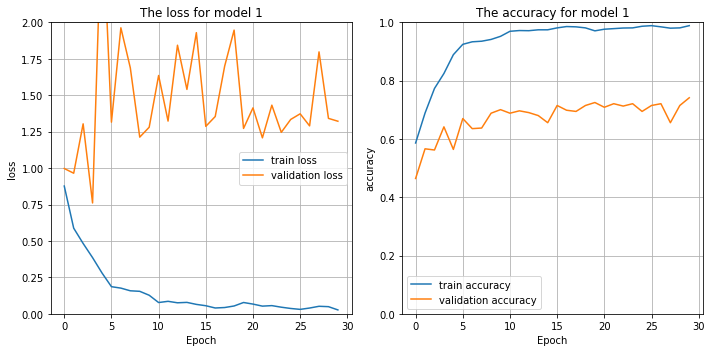

In [27]:
def plot_loss(history, mid):
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.ylim([0, 2])
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title(f'The loss for model {mid}')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['categorical_accuracy'], label='train accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='validation accuracy')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.title(f'The accuracy for model {mid}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
plot_loss(History, 1)

In [28]:
m1 = None
tf.keras.backend.clear_session()

## Model 2: Multitask learning

In [29]:
def weighted_binary_cross_entropy(weights: dict, from_logits: bool = False):
    assert 0 in weights
    assert 1 in weights

    def weighted_cross_entropy_fn(y_true, y_pred):
        
        size = tf.math.reduce_prod(tf.shape(y_pred))
        
        tf_y_true = tf.reshape(tf.cast(y_true, dtype=y_pred.dtype), [size,1])
        tf_y_pred = tf.reshape(tf.cast(y_pred, dtype=y_pred.dtype), [size,1])
        
        weights_v = tf.cast(tf.where(tf.equal(tf_y_true, 1), weights[1], weights[0]), dtype=y_pred.dtype)
        ce = tf.reshape(metrics.binary_crossentropy(tf_y_true, tf_y_pred, from_logits=from_logits), [size,1])
        weighted_loss = tf.math.multiply(ce, weights_v)
        loss = tf.math.reduce_mean(weighted_loss)
        return loss

    return weighted_cross_entropy_fn

In [30]:
def model2_build():
    tf.random.set_seed(20211012)
    
    input_layer = layers.Input((224,224,3))
    EfficientNet_encode = keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet', 
        input_tensor=input_layer, 
        pooling = None)
    
    ## Output1: Pathology
    x = layers.GlobalAveragePooling2D()(EfficientNet_encode.output)
    x = layers.Flatten()(x)
    x = layers.Dense(units=1024, activation=tf.nn.leaky_relu)(x)
    x = layers.Dense(units=512, activation=tf.nn.leaky_relu)(x)
    x = layers.Dense(units=128, activation=tf.nn.leaky_relu)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(units=2, activation='softmax', name="Pathology")(x)
    
    ## Output2: ROI
    
    ##7x7 -> 14x14
    x = layers.UpSampling2D((2, 2))(EfficientNet_encode.output)
    x = layers.Concatenate(axis = 3)([x, EfficientNet_encode.get_layer('block5c_add').output])
    x = layers.Conv2D(128, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.2)(x)
    x = layers.LeakyReLU()(x)
    
    ##14x14-> 28x28
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Concatenate(axis = 3)([x, EfficientNet_encode.get_layer('block3b_add').output])
    x = layers.Conv2D(128, (3, 3), activation=tf.nn.leaky_relu, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.2)(x)
    x = layers.LeakyReLU()(x)
    
    ##28x28 -> 56x56
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Concatenate(axis = 3)([x, EfficientNet_encode.get_layer('block2b_add').output])
    x = layers.Conv2D(128, (5, 5), activation=tf.nn.leaky_relu, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.2)(x)
    x = layers.LeakyReLU()(x)
    
    ##56x56 -> 112x112
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Concatenate(axis = 3)([x, EfficientNet_encode.get_layer('block1a_project_bn').output])
    x = layers.Conv2D(128, (7, 7), activation=tf.nn.leaky_relu, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.2)(x)
    x = layers.LeakyReLU()(x)
    
    ##112x112 -> 224x224(ROI size)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (7, 7), activation=tf.nn.leaky_relu, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.SpatialDropout2D(0.2)(x)
    x = layers.LeakyReLU()(x)

    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name = 'ROI')(x)

    model = keras.Model(input_layer, [out, decoded])
    
    model.compile(loss= {
                        'Pathology': keras.losses.CategoricalCrossentropy(),
                        'ROI'      : weighted_binary_cross_entropy(ROIweights)
                        },
                  optimizer=keras.optimizers.Adam(learning_rate = 0.002), 
                  metrics={
                        'Pathology': metrics.CategoricalAccuracy(),
                        'ROI'      : metrics.BinaryAccuracy()
                        }
                 )

    return model

In [31]:
m2 = model2_build()

In [32]:
!mkdir -p /kaggle/working/m2
model_checkpoint_callback_m2 = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/m2/m2-{epoch:02d}.hdf5',
    save_best_only=False,
    save_weights_only=False)

In [33]:
History2 = m2.fit(
    x = X_train, 
    y = {'Pathology': Y1_train, 'ROI': Y2_train},
    validation_data = (X_val, {'Pathology': Y1_val, 'ROI': Y2_val}),
    batch_size = 30,
    epochs=100,
    verbose = 1,
    callbacks = model_checkpoint_callback_m2
)

Epoch 1/100
66/66 [==============================] - 79s 981ms/step - loss: 1.8427 - Pathology_loss: 0.9621 - ROI_loss: 0.8806 - Pathology_categorical_accuracy: 0.5244 - ROI_binary_accuracy: 0.5953 - val_loss: 2.1580 - val_Pathology_loss: 1.5083 - val_ROI_loss: 0.6498 - val_Pathology_categorical_accuracy: 0.5580 - val_ROI_binary_accuracy: 0.7563
Epoch 2/100
66/66 [==============================] - 59s 899ms/step - loss: 1.0819 - Pathology_loss: 0.7307 - ROI_loss: 0.3512 - Pathology_categorical_accuracy: 0.6102 - ROI_binary_accuracy: 0.7748 - val_loss: 1.4396 - val_Pathology_loss: 1.0546 - val_ROI_loss: 0.3850 - val_Pathology_categorical_accuracy: 0.5866 - val_ROI_binary_accuracy: 0.7465
Epoch 3/100
66/66 [==============================] - 59s 897ms/step - loss: 1.0696 - Pathology_loss: 0.6869 - ROI_loss: 0.3827 - Pathology_categorical_accuracy: 0.6399 - ROI_binary_accuracy: 0.7358 - val_loss: 2.4219 - val_Pathology_loss: 1.8226 - val_ROI_loss: 0.5994 - val_Pathology_categorical_accurac

In [34]:
!ls -l /kaggle/working/m2/

total 11748800
-rw-r--r-- 1 root root 120305984 Oct 15 13:59 m2-01.hdf5
-rw-r--r-- 1 root root 120305984 Oct 15 14:00 m2-02.hdf5
-rw-r--r-- 1 root root 120305984 Oct 15 14:01 m2-03.hdf5
-rw-r--r-- 1 root root 120305984 Oct 15 14:02 m2-04.hdf5
-rw-r--r-- 1 root root 120305984 Oct 15 14:03 m2-05.hdf5
-rw-r--r-- 1 root root 120305984 Oct 15 14:04 m2-06.hdf5
-rw-r--r-- 1 root root 120305984 Oct 15 14:05 m2-07.hdf5
-rw-r--r-- 1 root root 120305984 Oct 15 14:06 m2-08.hdf5
-rw-r--r-- 1 root root 120305984 Oct 15 14:07 m2-09.hdf5
-rw-r--r-- 1 root root 120305984 Oct 15 14:08 m2-10.hdf5
-rw-r--r-- 1 root root 120305984 Oct 15 15:38 m2-100.hdf5
-rw-r--r-- 1 root root 120305984 Oct 15 14:09 m2-11.hdf5
-rw-r--r-- 1 root root 120305984 Oct 15 14:10 m2-12.hdf5
-rw-r--r-- 1 root root 120305984 Oct 15 14:11 m2-13.hdf5
-rw-r--r-- 1 root root 120305984 Oct 15 14:12 m2-14.hdf5
-rw-r--r-- 1 root root 120305984 Oct 15 14:13 m2-15.hdf5
-rw-r--r-- 1 root root 120305984 Oct 15 14:14 m2-16.hdf5
-rw-r--r-- 1 ro

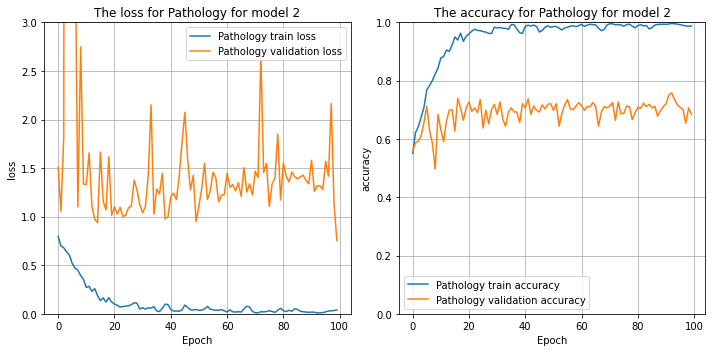

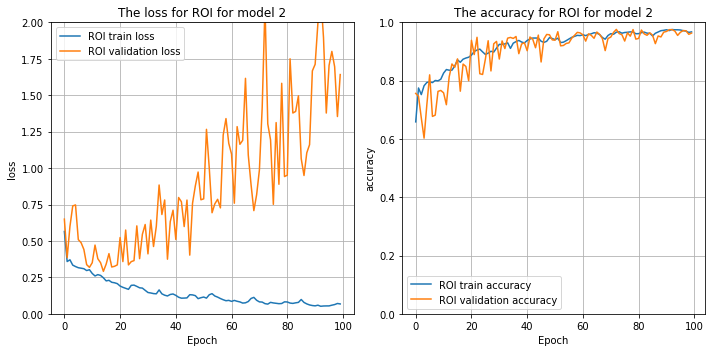

In [35]:
def plot_loss_m2(history, mid):
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['Pathology_loss'], label='Pathology train loss')
    plt.plot(history.history['val_Pathology_loss'], label='Pathology validation loss')
    plt.ylim([0, 3])
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title(f'The loss for Pathology for model {mid}')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['Pathology_categorical_accuracy'], label='Pathology train accuracy')
    plt.plot(history.history['val_Pathology_categorical_accuracy'], label='Pathology validation accuracy')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.title(f'The accuracy for Pathology for model {mid}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['ROI_loss'], label='ROI train loss')
    plt.plot(history.history['val_ROI_loss'], label='ROI validation loss')
    plt.ylim([0, 2])
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title(f'The loss for ROI for model {mid}')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['ROI_binary_accuracy'], label='ROI train accuracy')
    plt.plot(history.history['val_ROI_binary_accuracy'], label='ROI validation accuracy')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.title(f'The accuracy for ROI for model {mid}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
plot_loss_m2(History2, 2)